# Libraries

In [6]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '.'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [282]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from src.data import get_monthly_market_data, make_yearly_returns
from src import analysis as an

%matplotlib inline

Here's what we want to do:

1. Lookup a symbol representing a financial asset (e.g. SPY)
2. Compute the symbol utility as an equity-indexed annuity (constant growth rate)
    - Annualized return (1 year return with compounding)
3. Compute the risk on monthly or annual returns

# Get the ticker

In [238]:
ticker = 'SOXX'

monthly_returns_df = get_monthly_market_data(
  tickers = [ticker],
  interval = '1mo',
  returns_only = False
)

[*********************100%***********************]  1 of 1 completed


In [239]:
print('Dates:')
print('============')
print(pd.Series(monthly_returns_df.index).describe())

Dates:
count                     291
unique                    291
top       2009-08-01 00:00:00
freq                        1
first     2001-08-01 00:00:00
last      2021-03-03 00:00:00
Name: date, dtype: object


<ipython-input-239-fb1093349760>:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(pd.Series(monthly_returns_df.index).describe())


# Returns Analysis

## Monthly Closing Prices

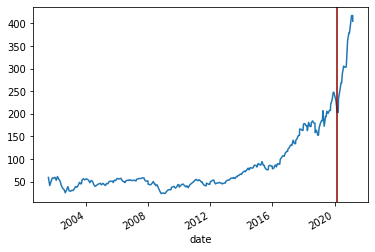

In [240]:
monthly_returns_df['adjusted_close'].ffill().plot();
plt.axvline('2020-03-01', color = 'darkred');

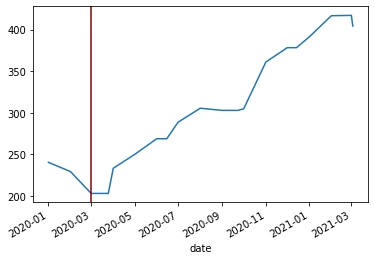

In [241]:
monthly_returns_df.loc['2020':, 'adjusted_close'].ffill().plot();
plt.axvline('2020-03-01', color = 'darkred');

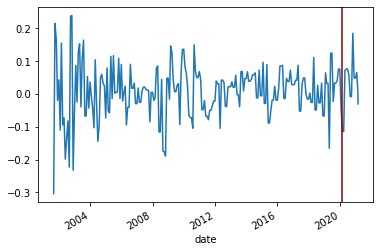

In [242]:
monthly_returns_df['period_return'].plot();
plt.axvline('2020-03-01', color = 'darkred');

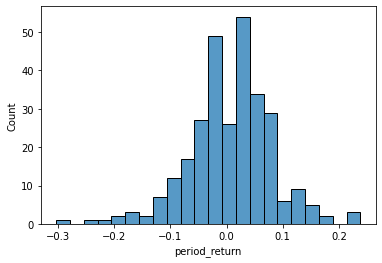

In [243]:
sns.histplot(monthly_returns_df['period_return']);

## Monthly Returns

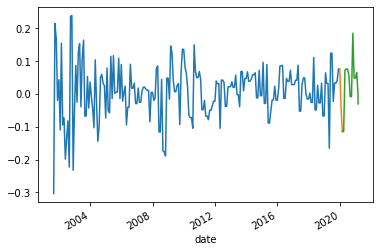

In [253]:
monthly_returns_df.loc[:'2019', 'period_return'].plot(label = 'Pre-2020');
monthly_returns_df.loc['2020':'2020-03-01', 'period_return'].plot(label = 'Pre-COVID');
monthly_returns_df.loc['2020-03-01':, 'period_return'].plot(label = 'Post-COVID');

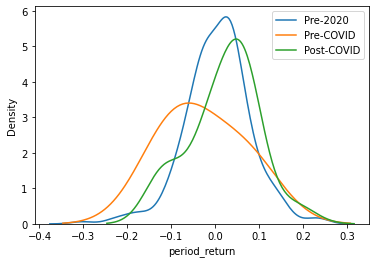

In [254]:
sns.kdeplot(monthly_returns_df.loc[:'2019', 'period_return'], label = 'Pre-2020')
sns.kdeplot(monthly_returns_df.loc['2020':'2020-03-01', 'period_return'], label = 'Pre-COVID')
sns.kdeplot(monthly_returns_df.loc['2020-03-01':, 'period_return'], label = 'Post-COVID')
plt.legend();

In [255]:
monthly_returns_df['period_return'].describe()

count    290.000000
mean       0.006695
std        0.074718
min       -0.303457
25%       -0.034416
50%        0.010785
75%        0.048024
max        0.238356
Name: period_return, dtype: float64

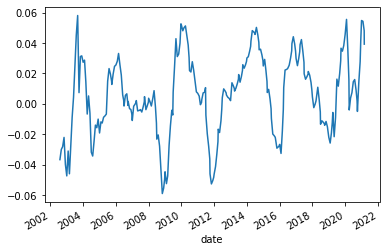

In [273]:
monthly_returns_df.rolling(12)['period_return'].mean().plot(label = 'Mean');

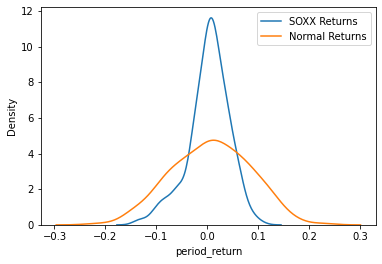

In [143]:
normal_rvs = stats.norm.rvs(0.006820, 0.074815, size = len(monthly_returns))

sns.kdeplot(monthly_returns, label = f'{ticker} Returns')
sns.kdeplot(normal_rvs, label = 'Normal Returns')
plt.legend();

In [129]:
monthly_returns_df.describe()

,open,close,adjusted_close,period_return
count,236.000000,236.000000,236.000000,289.000000
mean,93.211441,94.374534,88.157408,0.006820
std,71.677504,74.359976,75.598272,0.074815
min,26.090000,27.070000,23.425468,-0.303457
25%,51.195001,51.142501,44.890856,-0.035687
50%,62.990000,62.190001,53.902239,0.010785
75%,94.042501,95.442501,89.714682,0.048024
max,414.299988,416.910004,416.910004,0.238356


In [300]:
an.is_normal(monthly_returns_df['period_return'])

False

In [145]:
stats.kurtosis(normal_rvs)

-0.30876218098045216

In [147]:
stats.kurtosis(monthly_returns.dropna())

0.8502473271195434

In [148]:
stats.skew(monthly_returns.dropna())

-0.6782859846007051

## Compute annualized return across periods

In [274]:
an.annualized_return(monthly_returns_df['period_return'])

0.047080916236842185

In [275]:
an.annualized_return(monthly_returns_df.loc[:'2019', 'period_return'])

0.03581661710848727

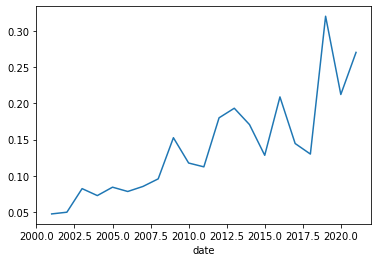

In [276]:
years = monthly_returns_df.index.year.unique()
ars = []

for year in years:
  ar = an.annualized_return(monthly_returns_df.loc[str(year):, 'period_return'])
  ars.append(ar)

annualized_returns = pd.Series(ars, index = years)
annualized_returns.plot();

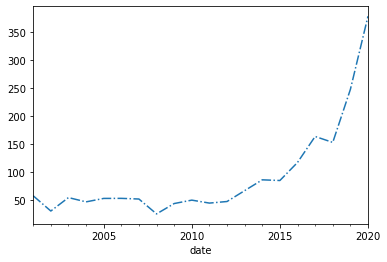

In [277]:
last_months = [f'{year}-12-01' for year in years[:-1]]
annual_closing = monthly_returns_df.loc[last_months, 'adjusted_close']
annual_closing.plot(ls = 'dashdot');
# plt.axvline('2020-03-01', color = 'darkred');

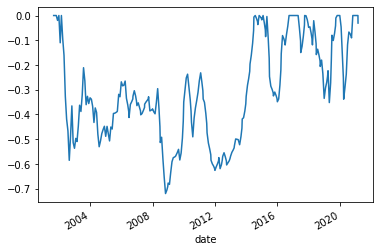

In [278]:
an.drawdown(monthly_returns_df['period_return'])['drawdown'].plot();

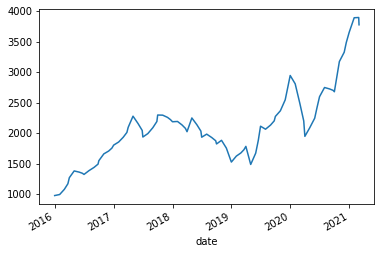

In [279]:
an.drawdown(monthly_returns_df.loc['2016':, 'period_return'])['wealth'].plot();

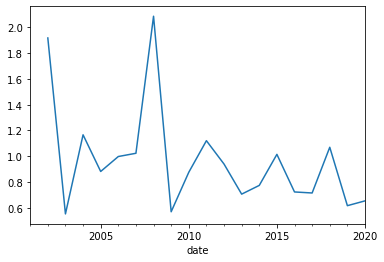

In [280]:
(annual_closing.shift() / annual_closing).plot();

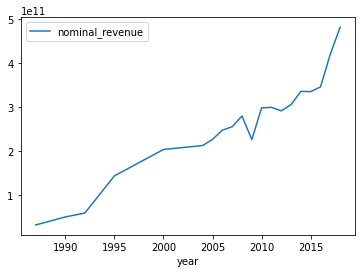

In [223]:
df = pd.read_csv('data/semiconductor_sales.csv', sep = '\t')[['year', 'nominal_revenue']].set_index('year')
df.plot();

# Variance Analysis

In [311]:
yearly_returns = make_yearly_returns(monthly_returns_df['adjusted_close'])

In [288]:
an.semi_deviation(monthly_returns_df['period_return'])

0.051693447464171954

In [289]:
an.semi_deviation(monthly_returns_df['period_return'], lower = False)

0.04560475915428157

In [291]:
an.var(monthly_returns_df['period_return'])

nan

In [297]:
an.var(monthly_returns_df['period_return'])

0.11467260769212695

In [299]:
an.var_gaussian(monthly_returns_df['period_return'])

0.11599319486074927

In [302]:
an.var_gaussian(monthly_returns_df['period_return'], modified = True)

0.12008302824381832

In [304]:
an.cvar_historical(monthly_returns_df['period_return'])

0.1647062502768984

In [312]:
an.cvar_historical(yearly_returns)

-0.5526295930588089